# Import dependencies
First, you may need to install 
* NumPy - `pip install numpy`,
* Matplotlib - `pip install matplotlib`,
* PyTorch - `pip install torch torchvision`.

Second, you need to change the current directory to `neural-ot`. Just run the cell below.

In [1]:
cd ..

/home/alartum/jupyter/ML/neural-ot


Now you can import all required dependencies.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap("Greys")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions import MultivariateNormal

from neural_ot.data_loading import ZipLoader, get_mean_covariance, CustomGaussian, DistributionDataset
from neural_ot.model import NeuralOT, Unflatten, Vector
from neural_ot.train import train

torch.manual_seed(42)

<Figure size 432x288 with 0 Axes>

# Global variables
First, we set `DEVICE` and `IS_CUDA` global variables.

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:1')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Second, we download MNIST dataset using `torchvision.datasets`. We normalize intensities from the default interval $[0, 1]$ to the interval $[-1, 1]$ via linear transformation $I' = (I - 0.5) / 0.5$ (as it was done in the original paper). Also for the generative modeling task we concatenate train and test sets to the single dataset, held in global variable `MNIST`.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([.5], [.5]),
])

mnist_train = datasets.MNIST('data/mnist', download=True, transform=transform, train=True)
mnist_test = datasets.MNIST('data/mnist', download=True, transform=transform, train=False)
MNIST = ConcatDataset([mnist_train, mnist_test])

In [5]:
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10
N_WORKERS = 4

In [6]:
MNIST_MEAN, MNIST_COV = get_mean_covariance(MNIST)

In [7]:
gauss = CustomGaussian(MNIST_MEAN, MNIST_COV)
gauss_dset = DistributionDataset(gauss, transform=lambda x: x.reshape(1, 28, 28))

batch_generator = ZipLoader(gauss_dset, MNIST, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH, 
                          pin_memory=IS_CUDA, return_idx=True, num_workers=N_WORKERS)

In [8]:
for (x_idx, x), (y_idx, y) in batch_generator:
    print(x_idx.shape, x.shape, y_idx.shape, y.shape)
    break

torch.Size([300]) torch.Size([300, 1, 28, 28]) torch.Size([300]) torch.Size([300, 1, 28, 28])


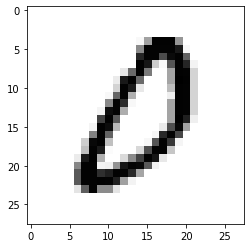

In [9]:
plt.imshow(y[0, 0].numpy())

In [10]:
source_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)

target_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)

# target_dual_net = Vector(initial=1e-2 * torch.randn(len(mnist)))

source_to_target_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 28 * 28),
    Unflatten(28, 28),
    nn.Tanh()
)

In [44]:
# ot = torch.load('generative_model.pth')
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=0.05, 
              from_discrete=False, to_discrete=False).to(DEVICE)

In [45]:
plan_optimizer = Adam(ot.parameters(), lr=1e-3)
plan_scheduler = MultiStepLR(plan_optimizer, [20, 75])

In [46]:
losses = train(ot.plan_criterion, plan_optimizer, batch_generator, n_epochs=300, device=DEVICE, 
               scheduler=plan_scheduler)

100%|██████████| 300/300 [01:58<00:00,  2.52it/s]


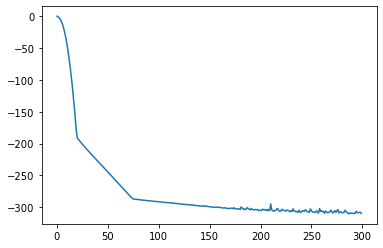

In [47]:
plt.plot(losses)

In [48]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = None # MultiStepLR(plan_optimizer, [10])

In [49]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, batch_generator, n_epochs=300, device=DEVICE, 
                       scheduler=mapping_scheduler)

100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


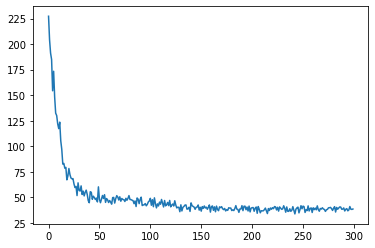

In [50]:
plt.plot(mapping_losses)

In [26]:
tmp_loader = ZipLoader(gauss_dset, batch_size=100, n_batches=1, 
                       pin_memory=IS_CUDA, return_idx=False, num_workers=N_WORKERS)
for x in tmp_loader:
    x = x[0]
    x = x.to(DEVICE)
    mapped = ot.map(x)
imgs = mapped[:, 0].detach().cpu().numpy()

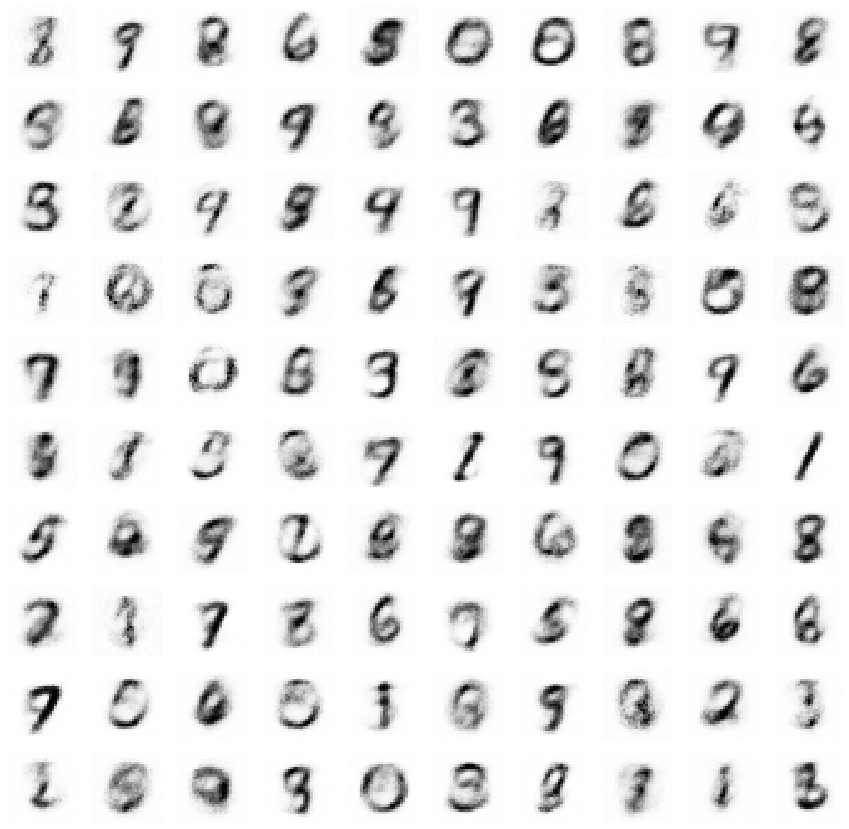

In [27]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax = axes[i // 10, i % 10]
    ax.imshow(img)
    ax.axis('off')
fig.savefig("generated.png")

In [55]:
torch.save(ot, 'generative_model.pth')